In [127]:
import math
import pandas as pd 
import torch 
from torch import nn
from d2l import torch as d2l

首先，计算 torch.arange((X.size(1))) 得到的是一个1维张量，该张量的元素从0开始递增，直到大于等于序列的最大长度为止。

然后，通过使用 [None, :]，该张量被转换为2维张量，其形状为 (1, seq_len)。这是为了便于与第二个张量进行比较。

最后，使用 valid_len[:, None] 获得一个形状为 (batch_size, 1) 的张量，该张量表示每个序列的有效长度。

接下来，在行 mask = torch.arange((X.size(1)), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None] 中，通过对第一个张量与第二个张量执行比较，我们将获得一个形状为 (batch_size, seq_len) 的掩码张量，其中的元素表示每个位置是否有效。

X的维度是（b,l,d)mask的维度是(b,l)，这里会进行维度扩展变成(b,l,d)


In [128]:
class PositionWiseFFN(nn.Module):
    '''基于位置的前馈网络'''
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [143]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))

tensor([[[ 0.0607, -0.0983,  0.5667,  0.4960, -0.2256,  0.4878, -0.6549,
          -0.0797],
         [ 0.0607, -0.0983,  0.5667,  0.4960, -0.2256,  0.4878, -0.6549,
          -0.0797],
         [ 0.0607, -0.0983,  0.5667,  0.4960, -0.2256,  0.4878, -0.6549,
          -0.0797]],

        [[ 0.0607, -0.0983,  0.5667,  0.4960, -0.2256,  0.4878, -0.6549,
          -0.0797],
         [ 0.0607, -0.0983,  0.5667,  0.4960, -0.2256,  0.4878, -0.6549,
          -0.0797],
         [ 0.0607, -0.0983,  0.5667,  0.4960, -0.2256,  0.4878, -0.6549,
          -0.0797]]], grad_fn=<ViewBackward0>)

In [130]:
def sequence_mask(X, valid_len, value=0):
    '''Mask irrelevant entries in sequences'''
    maxlen = X.size(1)  # (batch_size, max_length, feature_dim)
    mask = torch.arange((maxlen), dtype=torch.float32, 
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X
    

In [131]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor,  (batch_size, max_length, feature_dim)  [b,l,d]
    #  `valid_lens`: 1D or 2D tensor 如果只有一个，代表每一batch需要保存的数据，如果是二维，代表不同的batch里保存的数据
    # 关键在于对于2D数组来说b*l=a*B,对于1D数组来说b*L= 
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1) # 对data那一层数据进行平均
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1]) # 第一个参数是复制的次数，第二个参数复制的维度
        else:
            valid_lens = valid_lens.reshape(-1) 

        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [132]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, vaild_lens=None):
        d = queries.shape[-1]
         # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, vaild_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [133]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [134]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_heads, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)

        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [145]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [146]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [137]:
class PositionalEncoding(nn.Module):
    '''位置编码'''
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P，这个是一个batch里面的，(b, max_len, num_hiddens)
        self.P = torch.zeros((1, max_len, num_hiddens))
        # 这个是一次生成整个序列的，不是一个一个生成的，生成的维度为(max_len, D/2)
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1,1)/torch.pow(10000,torch.arange(
                0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X) # 在num_hiddens里取所有的奇数列
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

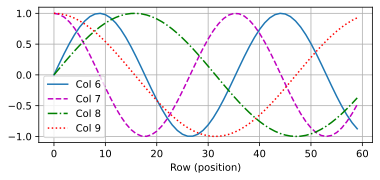

In [138]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [139]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
                dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [147]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 8] but got: [2, 24].

In [141]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                num_heads,num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [142]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 8] but got: [2, 24].